## Imports and Set Up

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00


In [3]:
import os
import random
import warnings
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from colorama import Fore, Style
from IPython.display import clear_output
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, VotingRegressor, StackingClassifier, StackingRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import (accuracy_score, cohen_kappa_score,
                             confusion_matrix, f1_score, mean_absolute_error,
                             mean_squared_error, precision_score, recall_score,
                             classification_report, make_scorer)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, ParameterGrid)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.under_sampling import NearMiss
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [4]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [5]:
def set_seed(seed_value=2024):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed(2024)

## Data Processing

### Load in Files

In [6]:
file_path = '/kaggle/input/child-mind-institute-problematic-internet-use'

In [7]:
TRAIN_CSV = f'{file_path}/train.csv'
TEST_CSV = f'{file_path}/test.csv'
SAMPLE_SUBMISSION_CSV = f'{file_path}/sample_submission.csv'
SERIES_TRAIN_DIR = f'{file_path}/series_train.parquet'
SERIES_TEST_DIR = f'{file_path}/series_test.parquet'


train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV) # 
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_CSV)

# Drop all the PCIAT variables as they are not present in the test data
for col in train_df.columns:
    if 'PCIAT' in col:
        train_df.drop(col, axis=1, inplace=True)

In [8]:
# Function to process individual time series files
def process_time_series(file_name, directory):
    df = pd.read_parquet(os.path.join(directory, file_name, 'part-0.parquet'))
    df = df.drop('step', axis=1)
    stats = df.describe().values.flatten()
    record_id = file_name.split('=')[1]
    return stats, record_id

In [9]:
# Function to load and aggregate time series data
def load_time_series_data(directory):
    file_names = os.listdir(directory)
    stats_list = []
    ids_list = []

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_time_series(fname, directory), file_names),
                            total=len(file_names)))

    for stats, record_id in results:
        stats_list.append(stats)
        ids_list.append(record_id)

    stats_df = pd.DataFrame(stats_list, columns=[f'stat_{i}' for i in range(len(stats_list[0]))])
    stats_df['id'] = ids_list
    return stats_df

In [10]:
train_series_df = load_time_series_data(SERIES_TRAIN_DIR)
# test_series_df = load_time_series_data(SERIES_TEST_DIR)

100%|██████████| 996/996 [01:11<00:00, 13.95it/s]


In [11]:
# Replace with missing for the split and then reassign the values at the end
train_df['sii'] = train_df['sii'].replace({np.nan: -1})
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=2024, stratify=train_df['sii'])
test_series_df = train_series_df[train_series_df.id.isin(test_df.id)]
train_series_df = train_series_df[train_series_df.id.isin(train_df.id)]
train_df['sii'] = train_df['sii'].replace({-1: np.nan})
test_df['sii'] = test_df['sii'].replace({-1: np.nan})


In [12]:
train_series_df

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,-0.054638,-0.163923,-0.114302,0.045252,-7.805897,0.000000,46.009533,4027.514893,5.415475e+13,4.438860,2.000000,30.202068,0.633126,0.513286,0.500372,0.132576,34.917873,0.000000,205.862213,108.451317,1.876976e+13,1.825557,0.000000,11.773107,-1.812031,-2.631380,-1.798073,0.0,-89.987045,0.0,0.0,3829.000000,0.000000e+00,1.0,2.0,15.0,-0.701660,-0.619076,-0.536432,0.007953,-32.948602,0.000000,2.520257,3958.000000,4.325125e+13,3.0,2.0,17.0,0.015846,-0.141810,-0.104193,0.019257,-6.358004,0.0,8.230733,4029.0,5.630500e+13,5.0,2.0,28.0,0.437897,0.148919,0.223770,0.036048,13.095750,0.0,24.750000,4146.0,6.978000e+13,6.0,2.0,38.0,1.850391,3.580182,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.000000,232.909103,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.000000,5.701968,-1.807955,-2.887664,-1.004992,0.0,-89.654587,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,223.0,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.000000,4.000000,3724.000000,2.128500e+13,2.0,2.0,228.0,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.0,10.050480,3812.0,4.360500e+13,4.0,2.0,233.0,0.517859,0.542323,0.312333,0.020598,18.462269,0.0,27.490936,3958.0,6.511000e+13,5.0,2.0,238.0,1.928769,3.234613,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,-0.499738,0.046381,-0.181152,0.056544,-11.934993,0.000000,77.305130,4106.425781,4.481677e+13,3.148264,3.000000,100.144516,0.454021,0.510668,0.412588,0.140594,27.367514,0.000000,274.848145,50.734318,2.038156e+13,1.169176,0.000000,5.653936,-1.903281,-3.150104,-1.020313,0.0,-89.540176,0.0,0.0,3853.000000,4.500000e+10,1.0,3.0,97.0,-0.873151,-0.255299,-0.485521,0.005643,-30.154542,0.000000,2.918126,4089.625000,2.888500e+13,3.0,3.0,98.0,-0.644505,0.088542,-0.191693,0.018467,-11.570901,0.0,7.863636,4111.0,4.727000e+13,3.0,3.0,99.0,-0.242422,0.381953,0.088555,0.048282,5.009753,0.0,21.022933,4140.0,6.094500e+13,4.0,3.0,100.0,1.021510,1.016589,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,0.007430,0.007583,-0.196510,0.053544,-12.847143,0.000000,9.369678,3958.604492,4.836642e+13,4.273992,2.303057,60.025017,0.586100,0.542189,0.474437,0.103401,32.552841,0.000000,54.104408,122.706802,1.868773e+13,2.023705,1.487018,7.396456,-1.684624,-2.405738,-1.023798,0.0,-89.968369,0.0,0.0,3468.000000,0.000000e+00,1.0,1.0,48.0,-0.530198,-0.412805,-0.556091,0.009947,-34.965618,0.000000,0.893617,3841.000000,3.526000e+13,3.0,1.0,53.0,0.022344,0.009674,-0.245181,0.027653,-15.000056,0.0,2.340206,3947.0,4.881000e+13,4.0,1.0,60.0,0.536801,0.443383,0.084469,0.057278,4.816339,0.0,6.200000,4064.0,6.330000e+13,6.0,4.0,67.0,5.908000,2.083693,

In [13]:
test_series_df

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
11,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,54656.0,-0.101927,0.038889,-0.128254,0.041191,-9.335292,0.000000,24.046852,4002.215820,4.950676e+13,3.472391,3.000000,125.755302,0.579921,0.530733,0.508932,0.059685,35.614758,0.000000,110.981293,119.975998,2.645317e+13,1.732290,0.000000,14.070252,-1.014123,-1.117504,-1.015372,0.0,-89.944153,0.0,0.0,3835.000000,0.000000e+00,1.0,3.0,109.0,-0.655789,-0.334381,-0.525129,0.007883,-33.832801,0.0,1.919666,3888.0,3.414500e+13,2.0,3.0,111.0,-0.111301,0.049473,-0.126540,0.021442,-7.461272,0.0,3.787899,3982.000000,5.166250e+13,3.0,3.0,127.0,0.380856,0.463455,0.215503,0.053100,12.891635,0.0,15.060341,4123.000000,7.181500e+13,5.0,3.0,139.0,1.011891,1.090084,2.047182,2.411536,89.323189,0.0,2573.399902,4171.0,8.639500e+13,7.0,3.0,146.0,e7d08824
17,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,393756.0,-0.006838,0.010657,-0.232763,0.020604,-15.658484,0.039314,40.237656,3846.995361,4.337012e+13,4.138086,2.000000,13.284460,0.585266,0.545101,0.504042,0.053991,34.832497,0.191974,173.845612,167.866653,2.498845e+13,1.985070,0.000000,6.586374,-2.181989,-2.503692,-1.012432,0.0,-89.748604,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,2.0,-0.531955,-0.423676,-0.659204,0.000139,-42.072853,0.0,4.655475,3741.0,2.166500e+13,2.0,2.0,8.0,-0.019659,0.023710,-0.261199,0.005723,-15.562552,0.0,9.995013,3818.000000,4.360000e+13,4.0,2.0,13.0,0.526247,0.456963,0.082472,0.018922,4.727961,0.0,21.000000,3970.000000,6.500000e+13,6.0,2.0,19.0,1.997215,1.879282,1.190707,4.781431,89.213989,1.0,2631.800049,4194.0,8.639500e+13,7.0,2.0,25.0,25849c6c
18,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,59380.0,0.268144,0.050723,0.060988,0.048870,4.518276,0.000000,87.920380,3969.688965,5.307810e+13,4.824368,4.000000,23.804462,0.529321,0.521577,0.541828,0.092858,38.955765,0.000000,229.316360,104.079353,2.040268e+13,1.579476,0.000000,14.170820,-1.698823,-1.919200,-1.010083,0.0,-89.821419,0.0,0.0,3788.000000,0.000000e+00,1.0,4.0,8.0,-0.046883,-0.374515,-0.318518,0.005529,-19.786970,0.0,2.731030,3894.0,4.019000e+13,4.0,4.0,9.0,0.388726,0.076551,0.032039,0.019742,1.628352,0.0,9.839325,3966.833252,5.436500e+13,5.0,4.0,22.0,0.699442,0.461147,0.442442,0.050854,27.207598,0.0,30.783947,4076.000000,6.955500e+13,6.0,4.0,32.0,1.288477,1.374236,1.153668,2.174635,89.295319,0.0,2635.000000,4152.0,8.639500e+13,7.0,4.0,54.0,c00c663c
21,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,346068.0,0.026980,0.435281,-0.241448,0.009940,-20.106930,0.591387,3.618404,3808.859619,4.322115e+13,4.111342,1.000000,37.202156,0.313924,0.505088,0.614045,0.038495,49.179070,0.483578,6.515615,136.809952,2.493300e+13,1.979066,0.000000,5.792164,-1.838956,-2.146103,-1.064392,0.0,-89.705360,0.0,0.0,3098.166748,0.000000e+00,1.0,1.0,27.0,-0.037226,0.022465,-0.957959,0.000000,-73.935036,0.0,1.000000,3741.0,2.162500e+13,2.0,1.0,32.0,-0.014784,0.367616,-0.222288,0.000898,-13.092836,1.0,1.310364,3798.750000,4.325500e+13,4.0,1.0,37.0,0.082636,0.969934,0.086984,0.003960,4.936125,1.0,3.000000,3906.000000,6.477000e+13,6.0,1.0,42.0,1.213309,1.669852,1.744264,2

### Encoding of Time Series Data

In [14]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, encoding_size * 3),
            nn.ReLU(),
            nn.Linear(encoding_size * 3, encoding_size * 2),
            nn.ReLU(),
            nn.Linear(encoding_size * 2, encoding_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, input_size * 2),
            nn.ReLU(),
            nn.Linear(input_size * 2, input_size * 3),
            nn.ReLU(),
            nn.Linear(input_size * 3, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
def encodedDataPrep(train, test):
    scaler = StandardScaler()
    scaled_data_train = scaler.fit_transform(train.drop('id', axis=1))
    scaled_data_test = scaler.transform(test.drop('id', axis=1))
    tensor_data_train = torch.FloatTensor(scaled_data_train)
    tensor_data_test = torch.FloatTensor(scaled_data_train)
    return tensor_data_train, tensor_data_test

In [16]:
def get_encoded_features(tensor_data, train=True, autoencoder=None, encoding_dim=60, epochs=100, batch_size=32):
    input_dim = tensor_data.shape[1]
    autoencoder = TimeSeriesAutoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for i in range(0, len(tensor_data), batch_size):
            batch = tensor_data[i:i + batch_size]
            optimizer.zero_grad()
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(tensor_data).numpy()

    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    return encoded_df, autoencoder

In [17]:
def encode_test_data(autoencoder, test_tensor):
    with torch.no_grad():
        encoded_data = autoencoder.encoder(test_tensor).numpy()
    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    return encoded_df

In [18]:
tensor_data_train, tensor_data_test = encodedDataPrep(train_series_df, test_series_df)
train_encoded, autoencoder = get_encoded_features(tensor_data_train)
test_encoded = encode_test_data(autoencoder, tensor_data_test)

train_encoded['id'] = train_series_df['id']
test_encoded['id'] = test_series_df['id']

train_df = train_df.merge(train_encoded, on='id', how='left')
test_df = test_df.merge(test_encoded, on='id', how='left')

Epoch [10/100], Loss: 1.0009
Epoch [20/100], Loss: 0.8658
Epoch [30/100], Loss: 0.7772
Epoch [40/100], Loss: 0.7546
Epoch [50/100], Loss: 0.7411
Epoch [60/100], Loss: 0.7356
Epoch [70/100], Loss: 0.7308
Epoch [80/100], Loss: 0.7283
Epoch [90/100], Loss: 0.7227
Epoch [100/100], Loss: 0.7261


### Imputation of Missing Numerical Values

In [19]:
# Imputing missing values using KNN imputer

def impute_missing_values(train_df, test_df, n_neighbors=5):
    # Select only numeric columns
    numeric_columns = train_df.select_dtypes(include=['float64', 'float32', 'int64']).columns

    # Initialize the KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit on the training dataset and transform both datasets
    train_imputed_array = imputer.fit_transform(train_df[numeric_columns])
    test_imputed_array = imputer.transform(test_df[numeric_columns])

    # Create DataFrames from the imputed arrays
    train_imputed = pd.DataFrame(train_imputed_array, columns=numeric_columns, index=train_df.index)
    test_imputed = pd.DataFrame(test_imputed_array, columns=numeric_columns, index=test_df.index)

    # Replace numeric columns with imputed data
    train_df[numeric_columns] = train_imputed
    test_df[numeric_columns] = test_imputed

    return train_df, test_df

In [20]:
# train_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Debug why we have inf values

# Apply imputation after splitting the dataset
train_df, test_df = impute_missing_values(train_df, test_df)

# Ensure target column 'sii' remains integer after imputation
train_df['sii'] = train_df['sii'].round().astype(int)
test_df['sii'] = test_df['sii'].round().astype(int)

# Imputation is needed in test set for some cases but not others to revisit

print(train_df.isna().sum())
print(test_df.isna().sum())

id                              0
Basic_Demos-Enroll_Season       0
Basic_Demos-Age                 0
Basic_Demos-Sex                 0
CGAS-Season                  1129
                             ... 
Enc_56                          0
Enc_57                          0
Enc_58                          0
Enc_59                          0
Enc_60                          0
Length: 120, dtype: int64
id                             0
Basic_Demos-Enroll_Season      0
Basic_Demos-Age                0
Basic_Demos-Sex                0
CGAS-Season                  276
                            ... 
Enc_56                         0
Enc_57                         0
Enc_58                         0
Enc_59                         0
Enc_60                         0
Length: 120, dtype: int64


### Categorical Processing

In [21]:
categorical_cols = list(train_df.select_dtypes(include=['object']).columns) #sii (outcome var) is categorical but we are encoding that differently
categorical_cols.remove('id')
print(categorical_cols)

def preprocess_categorical(df):
    for col in categorical_cols:
        df[col] = df[col].fillna('Missing').astype('category')
    return df

train_df = preprocess_categorical(train_df)
test_df = preprocess_categorical(test_df)

train_df = pd.get_dummies(train_df, columns = categorical_cols, drop_first=True, dtype='int')
test_df = pd.get_dummies(test_df, columns = categorical_cols, drop_first=True, dtype='int')

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [22]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [23]:
# Define the Quadratic Weighted Kappa metric
def quadratic_weighted_kappa(y_actual, y_predicted):
    return cohen_kappa_score(y_actual, y_predicted, weights='quadratic')

In [24]:
def make_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

### Resampling of Training Set

In [25]:
X = train_df.drop(columns='sii', axis=1)
y = train_df['sii'].astype(int)

# # Apply NearMiss for downsampling
# nm = NearMiss(sampling_strategy='majority')  # You can change version to 2 or 3
# # These are global variables for now
# X_res, y_res = nm.fit_resample(X, y)

## Baseline - Random Forest Model

In [26]:
def train_and_evaluate(model, param_dist, n_iter=10, eval_metric=None):
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=kf, n_jobs=-1, random_state=42, verbose=2, scoring=eval_metric)
    search.fit(X, y) # The resampling did not help
    best_model = search.best_estimator_
    y_pred = best_model.predict(X)
    print(f"Best Parameters: {search.best_params_}")
    return best_model, y_pred, y

In [27]:
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
}

### Classifier

In [28]:
# Training and evaluation function
def train_and_evaluate_classifier(model, param_dist, eval_metric=None, n_iter=10):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model

In [29]:
RF = RandomForestClassifier(random_state=42)
best_model = train_and_evaluate_classifier(RF, rf_param_dist, n_iter=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5}
Best Train QWK: 0.4227
Best Train Accuracy: 0.6957
Best Train F1: 0.6506


In [30]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.3959
Test Accuracy: 0.6793
Test F1: 0.6347


### Regression

In [31]:
# Function to apply thresholds to continuous predictions
def apply_thresholds(predictions, thresholds):
    return np.digitize(predictions, bins=thresholds)

# Function to optimize thresholds to maximize QWK
def optimize_thresholds(y_true, predictions):
    def loss_func(thresh):
        # Ensure thresholds are sorted
        thresh_sorted = np.sort(thresh)
        preds = apply_thresholds(predictions, thresh_sorted)
        return -quadratic_weighted_kappa(y_true, preds)
    
    initial_thresholds = [0.5, 1.5, 2.5]  # Initial guesses for thresholds
    bounds = [(0, 3)] * 3  # Assuming classes are 0,1,2,3
    result = minimize(loss_func, initial_thresholds, method='Nelder-Mead')
    return result.x

In [32]:
def train_and_evaluate_regressor(model, param_dist, n_iter=10, eval_metric=None):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    thresholds = optimize_thresholds(y, y_pred)
    y_pred = apply_thresholds(y_pred, thresholds)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model, thresholds

In [33]:
RF = RandomForestRegressor(random_state=42)
best_model, thresholds = train_and_evaluate_regressor(RF, rf_param_dist, n_iter=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5}
Best Train QWK: 0.6520
Best Train Accuracy: 0.7156
Best Train F1: 0.7098


In [34]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
raw_preds = best_model.predict(test_X)
y_test_pred = apply_thresholds(raw_preds, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")

Best Test QWK: 0.4924
Best Train Accuracy: 0.6503
Best Train F1: 0.6454


## Model 1 - Voting Classifier

In [35]:
# Training and evaluation function
def train_and_evaluate_classifier(model, param_dist, eval_metric=None, n_iter=10):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model

In [36]:
# Define the classifiers
rf = RandomForestClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
xgb_model = XGBClassifier(random_state=42, objective='multi:softprob', num_class=4, verbosity=0, learning_rate=0.05)
lgb_model = LGBMClassifier(random_state=42, objective='multiclass', num_class=4, verbose=-1, learning_rate=0.05)
catb_model = CatBoostClassifier(random_state=42, objective='MultiClass', verbose=False, learning_rate=0.05)

In [37]:
param_dist = {
            # 'rf__n_estimators': [100, 200, 300], 'rf__max_depth': [3], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1], 'rf__max_features': ['auto', 'sqrt', 'log2'],
            #   'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf'],
              'xgb__n_estimators': [200], 'xgb__max_depth': [2, 3],
              'lgb__n_estimators': [100], 'lgb__num_leaves': [5, 10],
              'cat__iterations': [100, 200], 'cat__depth': [2, 4]
              }

In [38]:

# Create an ensemble using VotingClassifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    voting='soft',
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [39]:
best_model = train_and_evaluate_classifier(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'lgb__num_leaves': 5, 'lgb__n_estimators': 100, 'cat__iterations': 100, 'cat__depth': 2}
Best Train QWK: 0.5495
Best Train Accuracy: 0.7453
Best Train F1: 0.7244


In [40]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.4367
Test Accuracy: 0.6995
Test F1: 0.6604


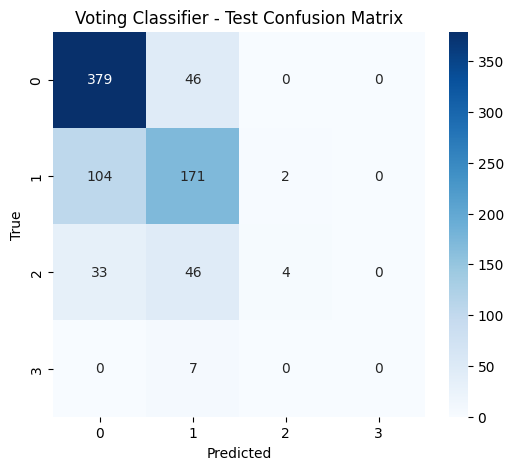

In [41]:
make_cm(y_test, y_test_pred, "Voting Classifier - Test")

## Model 1.5 - Stacking Classifier

In [42]:

# Create an ensemble using VotingClassifier with soft voting
ensemble_model = StackingClassifier(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [43]:
best_model = train_and_evaluate_classifier(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'lgb__num_leaves': 5, 'lgb__n_estimators': 100, 'cat__iterations': 100, 'cat__depth': 2}
Best Train QWK: 0.5308
Best Train Accuracy: 0.7629
Best Train F1: 0.7502


In [44]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.4556
Test Accuracy: 0.6856
Test F1: 0.6635


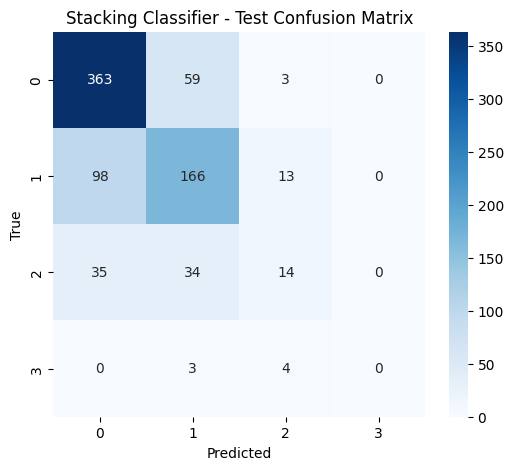

In [45]:
make_cm(y_test, y_test_pred, "Stacking Classifier - Test")

## Model 2 - Voting Regressor

In [46]:
# Function to apply thresholds to continuous predictions
def apply_thresholds(predictions, thresholds):
    return np.digitize(predictions, bins=thresholds)

# Function to optimize thresholds to maximize QWK
def optimize_thresholds(y_true, predictions):
    def loss_func(thresh):
        # Ensure thresholds are sorted
        thresh_sorted = np.sort(thresh)
        preds = apply_thresholds(predictions, thresh_sorted)
        return -quadratic_weighted_kappa(y_true, preds)
    
    initial_thresholds = [0.5, 1.5, 2.5]  # Initial guesses for thresholds
    bounds = [(0, 3)] * 3  # Assuming classes are 0,1,2,3
    result = minimize(loss_func, initial_thresholds, method='Nelder-Mead')
    return result.x

In [47]:
def train_and_evaluate_regressor(model, param_dist, n_iter=10, eval_metric=None):
    best_model, y_pred, y = train_and_evaluate(model, param_dist, n_iter, eval_metric)
    thresholds = optimize_thresholds(y, y_pred)
    y_pred = apply_thresholds(y_pred, thresholds)
    train_kappa = quadratic_weighted_kappa(y, y_pred)
    train_accuracy = accuracy_score(y, y_pred)
    train_f1 = f1_score(y, y_pred, average='weighted')
    print(f"Best Train QWK: {train_kappa:.4f}")
    print(f"Best Train Accuracy: {train_accuracy:.4f}")
    print(f"Best Train F1: {train_f1:.4f}")
    return best_model, thresholds

In [48]:
svm = SVC(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0, learning_rate=0.05)
lgb_model = LGBMRegressor(random_state=42, verbose=-1, learning_rate=0.05)
catb_model = CatBoostRegressor(random_state=42, verbose=False, learning_rate=0.05)

In [49]:
param_dist = {
            # 'rf__n_estimators': [100, 200, 300], 'rf__max_depth': [3], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1], 'rf__max_features': ['auto', 'sqrt', 'log2'],
            #   'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf'],
              'xgb__n_estimators': [200], 'xgb__max_depth': [2, 3],
              'lgb__n_estimators': [100], 'lgb__num_leaves': [5, 10],
              'cat__iterations': [100, 200], 'cat__depth': [2, 4]
              }

In [50]:
# Create an ensemble using VotingClassifier with soft voting
ensemble_model = VotingRegressor(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [51]:
best_model, thresholds = train_and_evaluate_regressor(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'lgb__num_leaves': 5, 'lgb__n_estimators': 100, 'cat__iterations': 100, 'cat__depth': 2}
Best Train QWK: 0.6140
Best Train Accuracy: 0.6796
Best Train F1: 0.6823


In [52]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
y_test_pred = apply_thresholds(y_test_pred, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.4962
Test Accuracy: 0.6250
Test F1: 0.6283


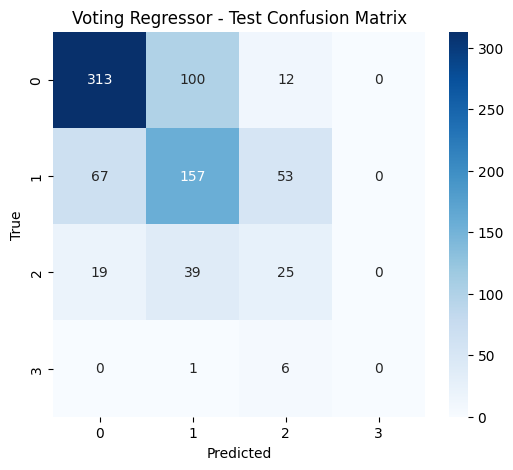

In [53]:
make_cm(y_test, y_test_pred, "Voting Regressor - Test")

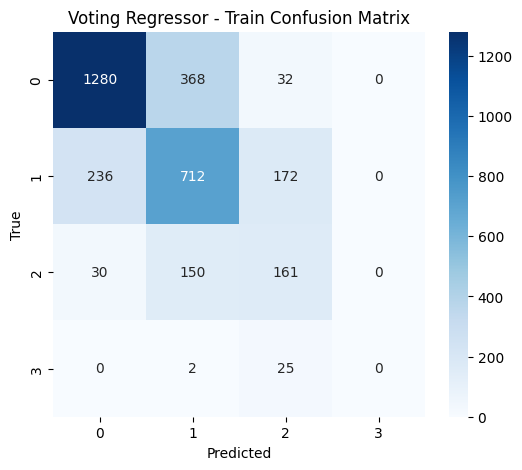

In [54]:
X_train = train_df.drop('sii', axis=1)
y_train = train_df['sii'].astype(int)
y_train_pred = best_model.predict(X_train)
y_train_pred = apply_thresholds(y_train_pred, thresholds)
make_cm(y_train, y_train_pred, "Voting Regressor - Train")

## Model 2.5 - Stacking Regressor

In [55]:
# Create an ensemble using VotingClassifier with soft voting
ensemble_model = StackingRegressor(
    estimators=[('lgb', lgb_model), 
                ('xgb', xgb_model), 
                ('cat', catb_model)
                # ('rf', rf) 
                # ,('svc', svc)
                ],
    # weights=[4.0, 4.0, 5.0],
    n_jobs=-1
)

In [56]:
best_model, thresholds = train_and_evaluate_regressor(ensemble_model, param_dist, n_iter=2)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .max_depth=5, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END .max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END .max_depth=5, min_samples_split=5, n_estimators=200; total time=  13.1s
[CV] END .max_depth=5, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END cat__depth=2, cat__iterations=100, lgb__n_estimators=100, lgb__num_leaves=5, xgb__max_depth=3, xgb__n_estimators=200; total time=  10.9s
[CV] END cat__depth=2, cat__iterations=100, lgb__n_estimators=100, lgb__num_leaves=5, xgb__max_depth=3, xgb__n_estimators=200; total time=  57.7s
[CV] END cat__depth=2, cat__iterations=100, lgb__n_estimators=100, lgb__num_leaves=5, xgb__max_depth=2, xgb__n_estimators=200; total time=   3.2s
[CV] END cat__depth=2, cat__iterations=100, lgb__n_estimators=100, lgb__num_leaves=5, xgb__max_depth=3, xgb__n_estimators=200; total time=   1.7s
[CV] END cat__depth=2, cat__itera

In [57]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
y_test_pred = best_model.predict(X_test)
y_test_pred = apply_thresholds(y_test_pred, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test QWK: {Fore.GREEN}{Style.BRIGHT}{test_kappa:.4f}{Style.RESET_ALL}")
print(f"Test Accuracy: {Fore.GREEN}{Style.BRIGHT}{test_accuracy:.4f}{Style.RESET_ALL}")
print(f"Test F1: {Fore.GREEN}{Style.BRIGHT}{test_f1:.4f}{Style.RESET_ALL}")

Test QWK: 0.4959
Test Accuracy: 0.6503
Test F1: 0.6448


## Model 3 - TabNet

In [58]:

# Function that instantiates a tabnet model.
def create_tabnet(n_d=32, n_steps=5, lr=0.02, gamma=1.5, 
                  n_independent=2, n_shared=2, lambda_sparse=1e-4, 
                  momentum=0.3, is_classifier=True):
    if is_classifier:
        tabnet_model = TabNetClassifier(
            n_d=n_d,
            n_a=n_d,
            n_steps=n_steps,
            gamma=gamma,
            lambda_sparse=lambda_sparse,
            seed=2024,
            verbose=1,
            device_name='cuda',
            optimizer_fn=torch.optim.Adam,
            scheduler_params = {"gamma": 0.95,
                            "step_size": 20},
            scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
        )
    else:
        tabnet_model = TabNetRegressor(
            n_d=n_d,
            n_a=n_d,
            n_steps=n_steps,
            gamma=gamma,
            lambda_sparse=lambda_sparse,
            seed=2024,
            verbose=1,
            device_name='cuda',
            optimizer_fn=torch.optim.Adam,
            scheduler_params = {"gamma": 0.95,
                            "step_size": 20},
            scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
        )
    return tabnet_model
                  
def getBestTabNetModel(is_classifier):
    # Generate the parameter grid.
    param_grid = dict(n_d = [64],
                    n_a = [64],
                    n_steps = [3],
                    gamma = [1.3],
                    lambda_sparse = [1e-2, 1e-3, 1e-4],
                    momentum = [0.2],
                    n_shared = [2],
                    n_independent = [2],
    )

    grid = ParameterGrid(param_grid)

    search_results = pd.DataFrame() 
    best_score = -np.inf
    best_model = None
    for params in tqdm(grid, desc="Hyperparameter Search", ncols=100):
        X_train, X_val, y_train, y_val = train_test_split(X.values.astype(np.float32), y.values.astype(np.int8), test_size=0.2, stratify=y)
        if is_classifier == False:
            y_train = y_train.reshape(-1, 1)
            y_val = y_val.reshape(-1, 1)
            eval_metric = ['rmse']
        else:
            eval_metric = ['logloss']
        tqdm.write(f"Before training - y_train shape: {str(y_train.shape)}, y_val shape: {str(y_val.shape)}")
        params['n_a'] = params['n_d'] # n_a=n_d always per the paper
        tabnet = create_tabnet(is_classifier=is_classifier)
        tabnet.set_params(**params)
        tabnet.fit(X_train=X_train, y_train=y_train, eval_set=[(X_val, y_val)], eval_name=['validation'], eval_metric=eval_metric, max_epochs=200, patience=20,
                batch_size=1024, virtual_batch_size=128)
        if is_classifier:
            y_pred = np.argmax(tabnet.predict_proba(X_val), axis=1)
            score = quadratic_weighted_kappa(y_val, y_pred)  # Convert probabilities to class labels and calculate accuracy
        else:
            y_pred = tabnet.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val.astype(np.float32), y_pred))
        if score > best_score:
            best_model = tabnet
            best_score = score
    return best_model

### Classifier

In [59]:
best_model = getBestTabNetModel(is_classifier=True)
train_X = X.values.astype(np.float32)
train_pred = np.argmax(best_model.predict_proba(train_X), axis=1)

train_kappa = quadratic_weighted_kappa(y, train_pred)
train_accuracy = accuracy_score(y, train_pred)
train_f1 = f1_score(y, train_pred, average='weighted')

print(f"Best Train QWK: {train_kappa:.4f}")
print(f"Best Train Accuracy: {train_accuracy:.4f}")
print(f"Best Train F1: {train_f1:.4f}")

Hyperparameter Search:   0%|                                                  | 0/3 [00:00<?, ?it/s]

Before training - y_train shape: (2534,), y_val shape: (634,)
epoch 0  | loss: 2.09701 | validation_logloss: 6.79532 |  0:00:00s
epoch 1  | loss: 1.36339 | validation_logloss: 8.22678 |  0:00:01s
epoch 2  | loss: 1.27479 | validation_logloss: 4.79282 |  0:00:01s
epoch 3  | loss: 1.16797 | validation_logloss: 3.61539 |  0:00:01s
epoch 4  | loss: 1.09121 | validation_logloss: 4.15329 |  0:00:01s
epoch 5  | loss: 0.99941 | validation_logloss: 5.31166 |  0:00:01s
epoch 6  | loss: 1.0115  | validation_logloss: 4.01675 |  0:00:01s
epoch 7  | loss: 0.9826  | validation_logloss: 3.24349 |  0:00:01s
epoch 8  | loss: 0.94703 | validation_logloss: 2.99843 |  0:00:01s
epoch 9  | loss: 0.91825 | validation_logloss: 3.88805 |  0:00:01s
epoch 10 | loss: 0.9508  | validation_logloss: 3.33851 |  0:00:01s
epoch 11 | loss: 0.91823 | validation_logloss: 3.33491 |  0:00:01s
epoch 12 | loss: 0.86542 | validation_logloss: 2.74478 |  0:00:02s
epoch 13 | loss: 0.88269 | validation_logloss: 2.0339  |  0:00:02s


Hyperparameter Search:  33%|██████████████                            | 1/3 [00:09<00:19,  9.68s/it]

epoch 82 | loss: 0.39038 | validation_logloss: 1.59216 |  0:00:09s
epoch 83 | loss: 0.34912 | validation_logloss: 1.71245 |  0:00:09s

Early stopping occurred at epoch 83 with best_epoch = 63 and best_validation_logloss = 1.34779


Hyperparameter Search:  33%|██████████████                            | 1/3 [00:09<00:19,  9.68s/it]

Before training - y_train shape: (2534,), y_val shape: (634,)
epoch 0  | loss: 2.06936 | validation_logloss: 4.97808 |  0:00:00s
epoch 1  | loss: 1.36589 | validation_logloss: 6.34448 |  0:00:00s
epoch 2  | loss: 1.38032 | validation_logloss: 4.46226 |  0:00:00s
epoch 3  | loss: 1.22466 | validation_logloss: 3.87433 |  0:00:00s
epoch 4  | loss: 1.14071 | validation_logloss: 4.31536 |  0:00:00s
epoch 5  | loss: 1.09051 | validation_logloss: 3.84159 |  0:00:00s
epoch 6  | loss: 1.03557 | validation_logloss: 6.2194  |  0:00:00s
epoch 7  | loss: 0.96738 | validation_logloss: 5.71551 |  0:00:00s
epoch 8  | loss: 0.97371 | validation_logloss: 6.47619 |  0:00:00s
epoch 9  | loss: 0.94227 | validation_logloss: 6.6965  |  0:00:00s
epoch 10 | loss: 0.91556 | validation_logloss: 4.8514  |  0:00:01s
epoch 11 | loss: 0.90911 | validation_logloss: 7.69786 |  0:00:01s
epoch 12 | loss: 0.91485 | validation_logloss: 5.84423 |  0:00:01s
epoch 13 | loss: 0.8788  | validation_logloss: 3.85432 |  0:00:01s


Hyperparameter Search:  67%|████████████████████████████              | 2/3 [00:14<00:06,  6.83s/it]

epoch 49 | loss: 0.63086 | validation_logloss: 1.96521 |  0:00:04s

Early stopping occurred at epoch 49 with best_epoch = 29 and best_validation_logloss = 1.45264
Before training - y_train shape: (2534,), y_val shape: (634,)
epoch 0  | loss: 2.09901 | validation_logloss: 4.43107 |  0:00:00s
epoch 1  | loss: 1.37294 | validation_logloss: 5.23886 |  0:00:00s
epoch 2  | loss: 1.31594 | validation_logloss: 4.22008 |  0:00:00s
epoch 3  | loss: 1.18163 | validation_logloss: 3.42894 |  0:00:00s
epoch 4  | loss: 1.06331 | validation_logloss: 3.1766  |  0:00:00s
epoch 5  | loss: 1.06122 | validation_logloss: 4.19437 |  0:00:00s
epoch 6  | loss: 1.01249 | validation_logloss: 3.07444 |  0:00:00s
epoch 7  | loss: 1.0015  | validation_logloss: 3.12696 |  0:00:00s
epoch 8  | loss: 0.98105 | validation_logloss: 1.98457 |  0:00:01s
epoch 9  | loss: 0.93939 | validation_logloss: 2.34554 |  0:00:01s
epoch 10 | loss: 0.93775 | validation_logloss: 1.79546 |  0:00:01s
epoch 11 | loss: 0.9202  | validation_

Hyperparameter Search: 100%|██████████████████████████████████████████| 3/3 [00:26<00:00,  8.85s/it]

Best Train QWK: 0.3866
Best Train Accuracy: 0.5694
Best Train F1: 0.5743


In [60]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
y_test_pred = np.argmax(best_model.predict_proba(test_X), axis=1)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")


Best Test QWK: 0.2680
Best Train Accuracy: 0.5038
Best Train F1: 0.5035


In [61]:
best_model

TabNetClassifier(n_d=64, n_a=64, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.2, lambda_sparse=0.0001, seed=2024, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.95, 'step_size': 20}, mask_type='sparsemax', input_dim=147, output_dim=4, device_name='cuda', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

### Regressor

In [62]:
y.values.astype(np.int8).reshape(-1, 1).shape

(3168, 1)

In [63]:
best_model = getBestTabNetModel(is_classifier=False)

Hyperparameter Search:   0%|                                                  | 0/3 [00:00<?, ?it/s]

Before training - y_train shape: (2534, 1), y_val shape: (634, 1)
epoch 0  | loss: 3.81312 | validation_rmse: 24.942399978637695|  0:00:00s
epoch 1  | loss: 2.12052 | validation_rmse: 18.802019119262695|  0:00:00s
epoch 2  | loss: 1.62238 | validation_rmse: 6.7062602043151855|  0:00:00s
epoch 3  | loss: 1.36842 | validation_rmse: 7.564589977264404|  0:00:00s
epoch 4  | loss: 1.20737 | validation_rmse: 4.2109599113464355|  0:00:00s
epoch 5  | loss: 0.98993 | validation_rmse: 2.5413498878479004|  0:00:00s
epoch 6  | loss: 0.85763 | validation_rmse: 2.0637800693511963|  0:00:01s
epoch 7  | loss: 0.86733 | validation_rmse: 2.5402700901031494|  0:00:01s
epoch 8  | loss: 0.72481 | validation_rmse: 1.8516600131988525|  0:00:01s
epoch 9  | loss: 0.67615 | validation_rmse: 1.1524499654769897|  0:00:01s
epoch 10 | loss: 0.63969 | validation_rmse: 1.4167200326919556|  0:00:01s
epoch 11 | loss: 0.65073 | validation_rmse: 1.3073699474334717|  0:00:01s
epoch 12 | loss: 0.5872  | validation_rmse: 1.7

Hyperparameter Search:  33%|██████████████                            | 1/3 [00:13<00:26, 13.29s/it]

Before training - y_train shape: (2534, 1), y_val shape: (634, 1)
epoch 0  | loss: 3.70675 | validation_rmse: 26.859249114990234|  0:00:00s
epoch 1  | loss: 2.21386 | validation_rmse: 16.390819549560547|  0:00:00s
epoch 2  | loss: 1.79148 | validation_rmse: 8.17117977142334|  0:00:00s
epoch 3  | loss: 1.42398 | validation_rmse: 4.248740196228027|  0:00:00s
epoch 4  | loss: 1.25114 | validation_rmse: 6.617300033569336|  0:00:00s
epoch 5  | loss: 1.48711 | validation_rmse: 4.676310062408447|  0:00:00s
epoch 6  | loss: 1.2194  | validation_rmse: 4.0288801193237305|  0:00:00s
epoch 7  | loss: 0.9549  | validation_rmse: 4.337170124053955|  0:00:00s
epoch 8  | loss: 0.87126 | validation_rmse: 3.864459991455078|  0:00:00s
epoch 9  | loss: 0.71263 | validation_rmse: 3.6516098976135254|  0:00:01s
epoch 10 | loss: 0.73032 | validation_rmse: 2.9529199600219727|  0:00:01s
epoch 11 | loss: 0.69229 | validation_rmse: 2.674880027770996|  0:00:01s
epoch 12 | loss: 0.62241 | validation_rmse: 1.69938004

Hyperparameter Search:  67%|████████████████████████████              | 2/3 [00:18<00:08,  8.38s/it]

Before training - y_train shape: (2534, 1), y_val shape: (634, 1)
epoch 0  | loss: 3.11346 | validation_rmse: 24.85572052001953|  0:00:00s
epoch 1  | loss: 2.27407 | validation_rmse: 15.994640350341797|  0:00:00s
epoch 2  | loss: 1.5601  | validation_rmse: 7.583749771118164|  0:00:00s
epoch 3  | loss: 1.25821 | validation_rmse: 7.38385009765625|  0:00:00s
epoch 4  | loss: 1.23449 | validation_rmse: 9.284059524536133|  0:00:00s
epoch 5  | loss: 1.01267 | validation_rmse: 5.510839939117432|  0:00:00s
epoch 6  | loss: 0.85671 | validation_rmse: 4.851409912109375|  0:00:00s
epoch 7  | loss: 0.78858 | validation_rmse: 6.289919853210449|  0:00:00s
epoch 8  | loss: 0.76792 | validation_rmse: 6.90024995803833|  0:00:00s
epoch 9  | loss: 0.74016 | validation_rmse: 5.122960090637207|  0:00:01s
epoch 10 | loss: 0.80287 | validation_rmse: 5.879670143127441|  0:00:01s
epoch 11 | loss: 0.61654 | validation_rmse: 5.4240498542785645|  0:00:01s
epoch 12 | loss: 0.60326 | validation_rmse: 2.313509941101

Hyperparameter Search: 100%|██████████████████████████████████████████| 3/3 [00:28<00:00,  9.60s/it]


In [64]:
raw_preds = best_model.predict(X.values.astype(np.float32))
thresholds = optimize_thresholds(y.values.astype(np.float32), raw_preds)
train_pred = apply_thresholds(raw_preds, thresholds)

train_kappa = quadratic_weighted_kappa(y, train_pred)
train_accuracy = accuracy_score(y, train_pred)
train_f1 = f1_score(y, train_pred, average='weighted')

print(f"Best Train QWK: {train_kappa:.4f}")
print(f"Best Train Accuracy: {train_accuracy:.4f}")
print(f"Best Train F1: {train_f1:.4f}")

Best Train QWK: -0.0400
Best Train Accuracy: 0.3504
Best Train F1: 0.3336


In [65]:
X_test = test_df.drop('sii', axis=1)
y_test = test_df['sii'].astype(int)
test_X = X_test.values.astype(np.float32)
raw_preds = best_model.predict(test_X)
y_test_pred = apply_thresholds(raw_preds, thresholds)
test_kappa = quadratic_weighted_kappa(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Best Test QWK: {test_kappa:.4f}")
print(f"Best Train Accuracy: {test_accuracy:.4f}")
print(f"Best Train F1: {test_f1:.4f}")

Best Test QWK: -0.0603
Best Train Accuracy: 0.3561
Best Train F1: 0.3326
